# Sheet 6

## 1 Autoencoders: theory and practice

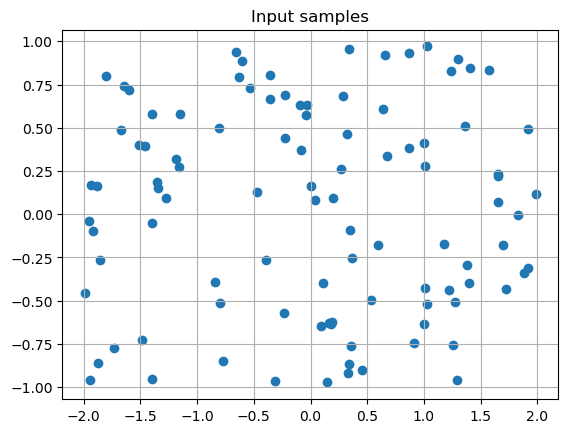

In [1]:
import torch
import matplotlib.pyplot as plt
from typing import Optional

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


# (a)
We use a ReLU activation on every layer except for the bottleneck as a
standard choice. For the bottleneck layer, we wanted to use the sigmoid
activation function, so that our latent representations are constrained to
[0,1] interval, but that would require a deeper network to invert the
function.

In [3]:

import torch
from torch import nn
import pytorch_lightning as pl


class Autoencoder(nn.Module):
    def __init__(
        self,
        dims: list[int],
        activation: Optional[type[nn.Module]] = None,
        bottleneck_activation: Optional[type[nn.Module]] = None,
        latent_dim=1,
        input_dim=2,
    ):
        if activation is None:
            activation = nn.ReLU
        if bottleneck_activation is None:
            bottleneck_activation = nn.Identity
        # dims: layer output dims starting from first hidden layer inclusive to
        # bottleneck exclusive
        super().__init__()

        layers = lambda dims: sum(
            [[nn.LazyLinear(i), activation()] for i in dims], start=[]
        )
        self.encoder = nn.Sequential(
            *layers(dims), nn.LazyLinear(latent_dim), bottleneck_activation()
        )
        self.decoder = nn.Sequential(*layers(dims[::-1]), nn.LazyLinear(input_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderModule(pl.LightningModule):
    def __init__(
        self,
        lr: Optional[float] = None,
        optim: Optional[type[torch.optim.Optimizer]] = None,
        **model_kwargs,
    ):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []
        if lr is None:
            lr = 0.001
        self.lr = lr
        if optim is None:
            optim = torch.optim.Adam
        self.optim = optim

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.lr)

        return optimizer

    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [4]:
def get_module(
    dims,
    act: Optional[type[nn.Module]] = None,
    bact: Optional[type[nn.Module]] = None,
    train=True,
    decoder=None,
    lr=None,
    optim=None,
    batchsize=None,
):
    module = AutoencoderModule(
        dims=dims, activation=act, bottleneck_activation=bact, lr=lr, optim=optim
    )
    if decoder is not None:
        for param in decoder.parameters():
            param.requires_grad = False
        module.autoencoder.decoder = decoder
    if not train:
        return module
    trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False)
    print("Model overview:", module)
    loader = data_loader
    if batchsize is not None:
        loader = DataLoader(dataset, batch_size=batchsize)
        print("dataloader size:", len(loader))
    trainer.fit(module, loader)
    return module


def plot_loss(module, desc):
    plt.title("loss plot")
    plt.plot(module.loss_curve, label=desc, alpha=0.5)


def plot_data(module, desc):
    # plots latent representation in the original space
    latent = module.autoencoder.encoder(data).detach().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=latent)
    plt.colorbar()
    plt.title(f"Latent representation of the data in the original space, model: {desc}")
    plt.ylim(-1, 1)
    plt.xlim(-2, 2)
    plt.show()


def plot_space(module, desc, start=-10, end=10):
    latent = torch.linspace(start, end, 1000).reshape(-1, 1)
    reconstructed = module.autoencoder.decoder(latent).detach().numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], c=latent)
    plt.colorbar()
    plt.title(f"Latent space embedded in the original space, model: {desc}")
    plt.ylim(-1, 1)
    plt.xlim(-2, 2)
    plt.show()

# (b)

In [5]:
pca = get_module([], bact=nn.Identity)
small = get_module([20, 10])
big = get_module([50, 50, 50])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nix/store/68cqjvbnv7xm4ff67zkhm6s1nxyb0z4h-python3-3.12.6-env/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 0      | train
----------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=1, bias=True)
      (1): Identity()
    )
    (decoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=2, bias=True)
    )
  )
)


/nix/store/68cqjvbnv7xm4ff67zkhm6s1nxyb0z4h-python3-3.12.6-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/nix/store/68cqjvbnv7xm4ff67zkhm6s1nxyb0z4h-python3-3.12.6-env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 0      | train
----------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=20, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=10, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=1, bias=True)
      (5): Identity()
    )
    (decoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=10, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=20, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=2, bias=True)
    )
  )
)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 0      | train
----------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=1, bias=True)
      (7): Identity()
    )
    (decoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=2, bias=True)
    )
  )
)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.


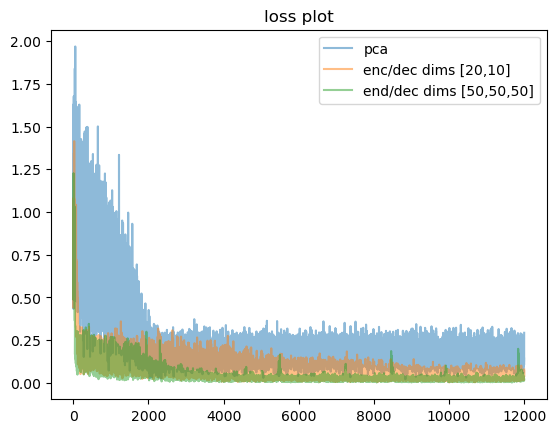

In [6]:
plot_loss(pca, "pca")
plot_loss(small, "enc/dec dims [20,10]")
plot_loss(big, "end/dec dims [50,50,50]")
plt.legend()
plt.show()

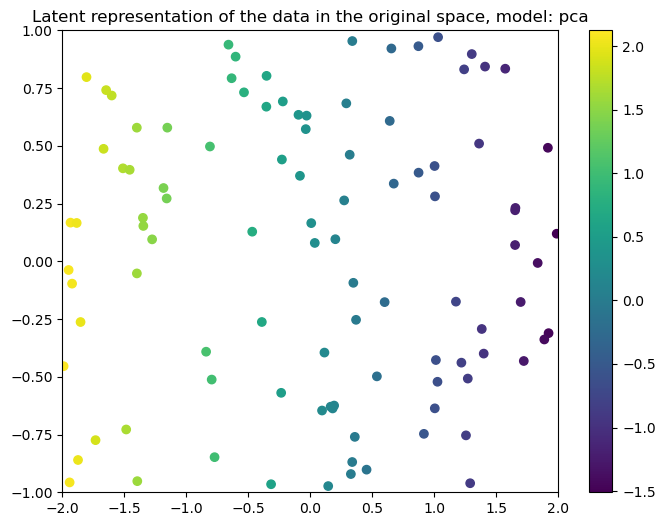

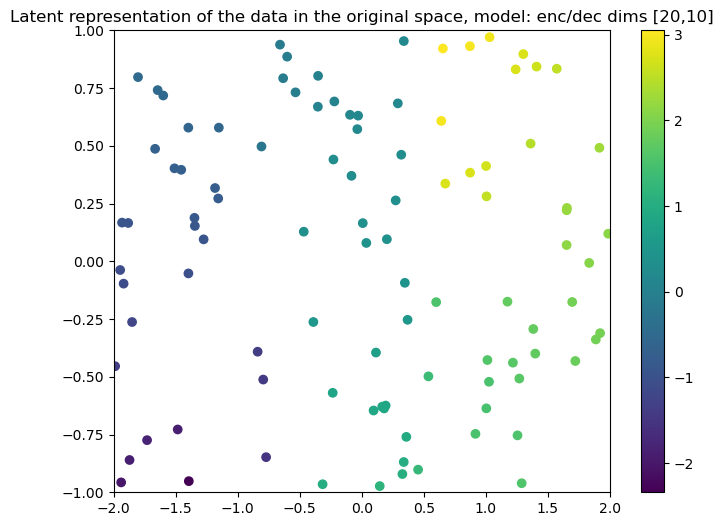

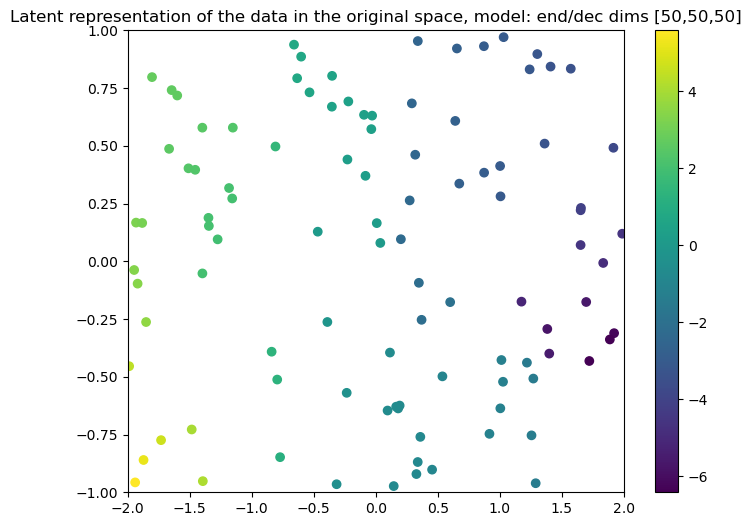

In [7]:
plot_data(pca, "pca")
plot_data(small, "enc/dec dims [20,10]")
plot_data(big, "end/dec dims [50,50,50]")

Plots look pretty much the same for all 3 models, except for the much slower convergence for PCA.

# (c)
- PCA - a line.
  - Trained: line will be oriented along the x axis, due to the initial distribution
  - Untrained: random orientation
- Small autoencoder - piecewise-linear curve.
  - Trained: the curve will be more or less "dense" in the region that contains data
  - Untrained: most of the breakpoints will be around the origin, due to weight initialization
- Bigger autoencoder - same as the small autoencoder, but with more breakpoints in the curve

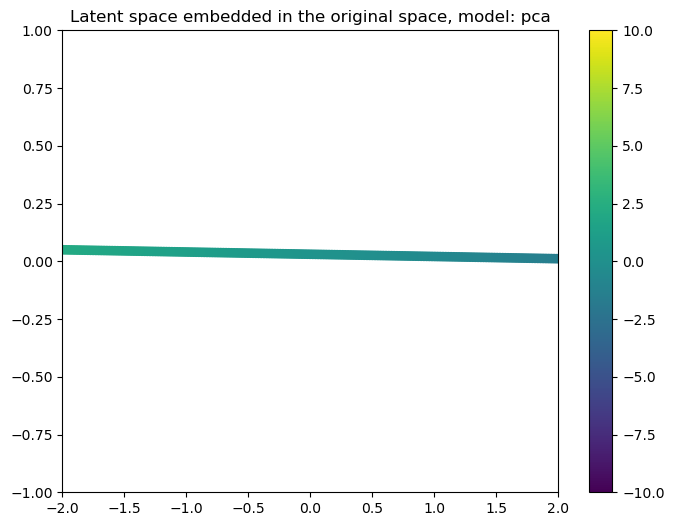

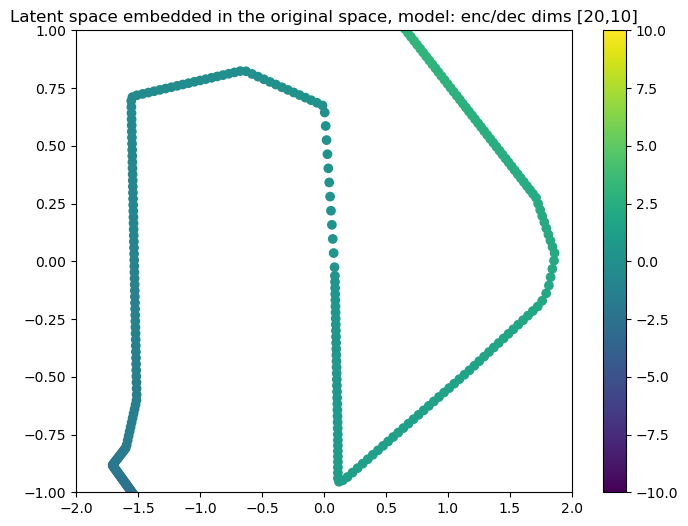

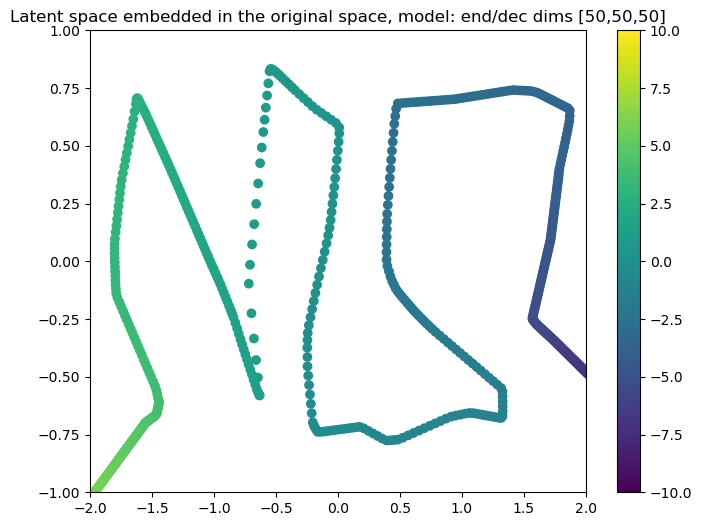

In [8]:
plot_space(pca, "pca", start=-10, end=10)
plot_space(small, "enc/dec dims [20,10]")
plot_space(big, "end/dec dims [50,50,50]")

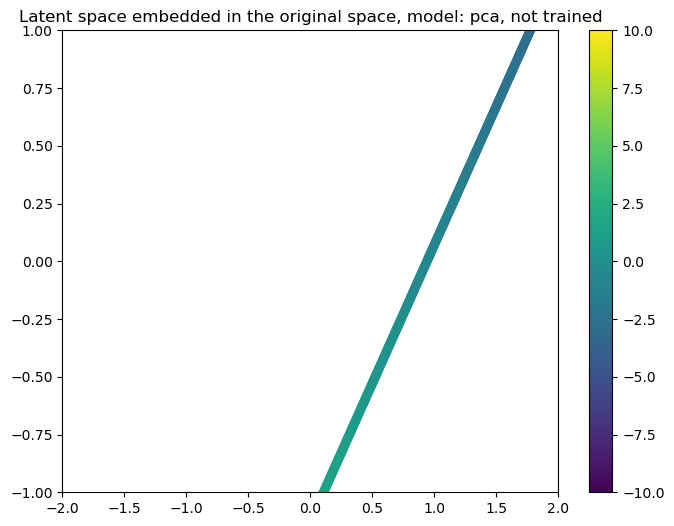

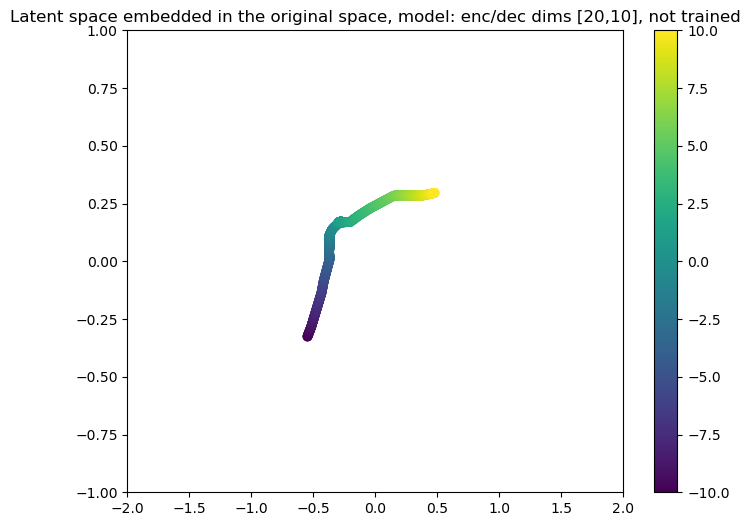

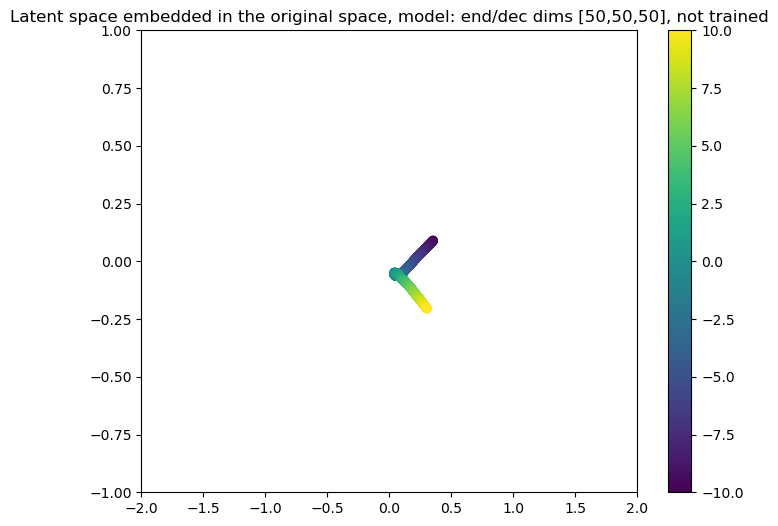

In [9]:
plot_space(get_module([], train=False), "pca, not trained", start=-10, end=10)
plot_space(get_module([20, 10], train=False), "enc/dec dims [20,10], not trained")
plot_space(
    get_module([50, 50, 50], train=False), "end/dec dims [50,50,50], not trained"
)

# (d)
We can observe the expected behaviour.

# (e)
Yes. If we pick a simple curve that goes through all n points in the original
space, then the latent space can be constructed as a parametrization of this
curve. Since we can always find an invertible parametrization, the rest is
just a question of finding an architecture that would be able to represent and
learn such a parametrization.

# (f)
The encoder will relearn approximately the same mapping, up to equivalence in
the latent space. More concretely, the further the point is from the image of
the decoder, the higher the change in latent space under such encoder
replacement it is going to experience.

# (g)
We chose to plot the absolute difference in the latent representation between two encoders

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.3 K  | train
----------------------------------------------------
0         Trainable params
5.3 K     Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=1, bias=True)
      (7): Identity()
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.


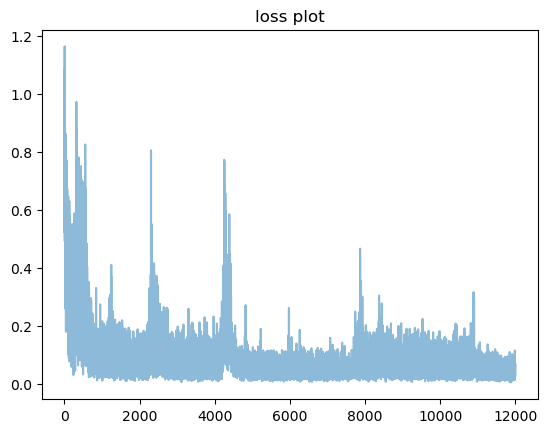

In [10]:
big2 = get_module([50, 50, 50], train=True, decoder=big.autoencoder.decoder, lr=0.01)
plot_loss(big2, desc="")

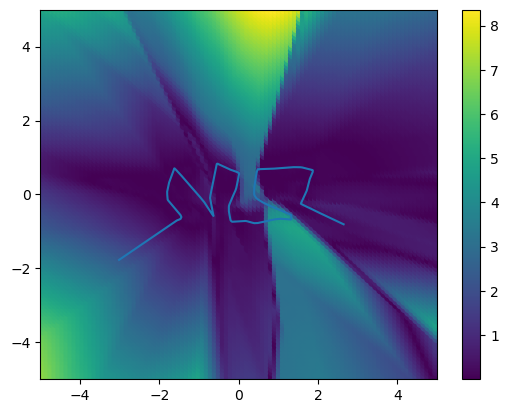

In [11]:
x, y = torch.meshgrid(
    torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100), indexing="ij"
)
grid = torch.stack((x, y), dim=-1).reshape(-1, 2)
latent_repr = big.autoencoder.encoder(grid)
latent_repr2 = big2.autoencoder.encoder(grid)
diff = torch.abs(latent_repr2 - latent_repr).detach().numpy()
plt.scatter(grid[:, 0], grid[:, 1], c=diff)

latent_space = torch.linspace(-10, 10, 1000).reshape(-1, 1)
reconstruction = big.autoencoder.decoder(latent_space).detach().numpy()
plt.plot(reconstruction[:, 0], reconstruction[:, 1])

plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.colorbar()
plt.show()

# (h)

In [12]:
import numpy as np

big_gd = get_module([50, 50, 50], optim=torch.optim.SGD, batchsize=data.shape[0])
gd_loss = big_gd.loss_curve

big_sgd = get_module([50, 50, 50], optim=torch.optim.SGD, batchsize=1, lr=3e-4)
sgd_loss = big_sgd.loss_curve

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 0      | train
----------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=1, bias=True)
      (7): Identity()
    )
    (decoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=2, bias=True)
    )
  )
)
dataloader size: 1


/nix/store/68cqjvbnv7xm4ff67zkhm6s1nxyb0z4h-python3-3.12.6-env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 0      | train
----------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=1, bias=True)
      (7): Identity()
    )
    (decoder): Sequential(
      (0): LazyLinear(in_features=0, out_features=50, bias=True)
      (1): ReLU()
      (2): LazyLinear(in_features=0, out_features=50, bias=True)
      (3): ReLU()
      (4): LazyLinear(in_features=0, out_features=50, bias=True)
      (5): ReLU()
      (6): LazyLinear(in_features=0, out_features=2, bias=True)
    )
  )
)
dataloader size: 100


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1000` reached.


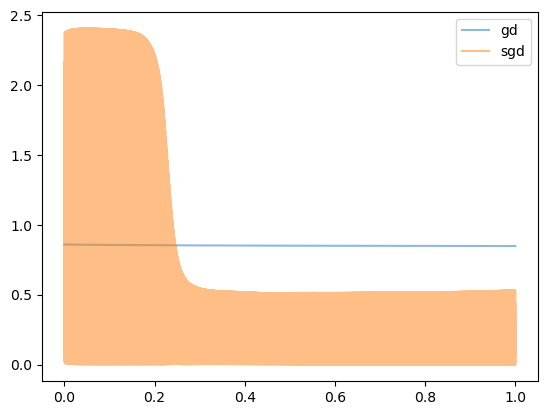

In [13]:
plt.plot(np.linspace(0, 1, len(gd_loss)), gd_loss, label="gd", alpha=0.5)
plt.plot(np.linspace(0, 1, len(sgd_loss)), sgd_loss, label="sgd", alpha=0.5)

plt.legend()
plt.show()

SGD loss is highly oscillatory